In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
# Mount Google Drive if not already mounted
#from google.colab import drive


# Load the trained model
model = lgb.Booster(model_file='final_lgbm_model_original2.txt')


# Load the latest stock data
#data = pd.read_csv('/content/drive/MyDrive/backtest_data.csv（副本）')
data = pd.read_csv('backtest_data.csv（副本）')
data = pd.DataFrame(data,columns=["tradingDate","windCode","return"])
#print(data.loc[data['windCode'] == '600346.XSHG', 'return'].values)

In [2]:
#Convert tradingDate and windCode of 2 datasets to same format 
import datetime
data2 = pd.read_csv('hs300_merged_market_data.csv')
dates = data2['tradingDate'].copy() # 创建数据副本

for i in range(len(dates)):
    date_str = dates[i]
    date_obj = pd.to_datetime(date_str, format='%Y/%m/%d')
    formatted_date_str = date_obj.strftime('%Y-%m-%d').replace('-', '-').replace('/', '-')
    formatted_date_str = '-'.join([d.zfill(2) for d in formatted_date_str.split('-')])
    dates[i] = formatted_date_str # 重新赋值到原始数据中

data2['tradingDate']=dates
data2['windCode'] = data2['windCode'].apply(lambda x: x.split('.')[1] + '.XSHE' if x.startswith('sz.') else x.split('.')[1] + '.XSHG')
print(data2)
#Use one example to validate code
print(data2.loc[data2['windCode'] == '600346.XSHG', 'close'].values)

       tradingDate     windCode    open    high     low   close  preclose   
0       2021-11-01  600031.XSHG   22.88   23.30   22.49   23.06     22.96  \
1       2021-11-02  600031.XSHG   23.07   23.16   22.22   22.41     23.06   
2       2021-11-03  600031.XSHG   22.41   22.58   21.97   22.55     22.41   
3       2021-11-04  600031.XSHG   22.43   22.77   22.25   22.61     22.55   
4       2021-11-05  600031.XSHG   22.59   23.20   22.38   23.00     22.61   
...            ...          ...     ...     ...     ...     ...       ...   
104890  2023-03-31  300769.XSHE  192.90  199.51  189.29  189.42    192.90   
104891  2023-04-03  300769.XSHE  189.96  191.80  184.40  185.21    189.42   
104892  2023-04-04  300769.XSHE  185.01  185.01  177.29  179.87    185.21   
104893  2023-04-06  300769.XSHE  179.63  179.88  176.48  178.15    179.87   
104894  2023-04-07  300769.XSHE  177.80  180.50  176.51  178.00    178.15   

             volume        amount    turn  pctChg  
0        97755013.0  2.

In [3]:
#Merge the close volumn with backtest_dataset
# 读取某些列，生成新的DataFrame
df2_data = pd.DataFrame(data2,columns=["tradingDate","windCode","close"])
print(data)
print(df2_data)
data=pd.merge(data,df2_data,how="inner",on=["tradingDate","windCode"])
print(data)

      tradingDate     windCode    return
0      2021-11-01  000002.XSHE -0.109830
1      2021-11-10  000002.XSHE -0.472381
2      2021-11-11  000002.XSHE -0.690147
3      2021-11-12  000002.XSHE -0.747660
4      2021-11-15  000002.XSHE -0.758002
...           ...          ...       ...
76434  2023-03-09  688981.XSHG -0.456323
76435  2023-04-03  688981.XSHG -0.637678
76436  2023-04-04  688981.XSHG -0.755875
76437  2023-04-06  688981.XSHG -0.718851
76438  2023-04-07  688981.XSHG -0.871309

[76439 rows x 3 columns]
       tradingDate     windCode   close
0       2021-11-01  600031.XSHG   23.06
1       2021-11-02  600031.XSHG   22.41
2       2021-11-03  600031.XSHG   22.55
3       2021-11-04  600031.XSHG   22.61
4       2021-11-05  600031.XSHG   23.00
...            ...          ...     ...
104890  2023-03-31  300769.XSHE  189.42
104891  2023-04-03  300769.XSHE  185.21
104892  2023-04-04  300769.XSHE  179.87
104893  2023-04-06  300769.XSHE  178.15
104894  2023-04-07  300769.XSHE  178.00

[

In [4]:
selected_codes = data[data['tradingDate'] == '2021-11-01']['windCode'][data['return'].notnull()].unique()
print(selected_codes)

X_column_original=['alpha047', 'alpha076', 'alpha063', 'alpha115', 'alpha005', 'alpha057',
       'alpha139', 'alpha016', 'alpha145', 'alpha064', 'alpha008', 'alpha028',
       'alpha014', 'alpha121', 'alpha010', 'alpha127', 'alpha146', 'alpha066',
       'alpha108', 'alpha157', 'alpha078', 'alpha073', 'alpha041', 'alpha029',
       'alpha179', 'alpha170', 'alpha065', 'alpha062', 'alpha048', 'alpha159',
       'alpha070', 'alpha015', 'alpha022', 'alpha033', 'alpha168', 'alpha113',
       'alpha102', 'alpha074', 'alpha090', 'alpha025', 'alpha083', 'alpha104',
       'alpha006', 'alpha176', 'alpha019', 'alpha099', 'alpha018', 'alpha020',
       'alpha080', 'alpha001'] 
    
def X_input_original(filepath,date,code):
  data1=pd.read_csv(filepath)
  input=data1[(data1['tradingDate'] == date) & (data1['windCode'] == code)][X_column_original]
  return input

# Load input data for 2021-11-01
X_original = X_input_original('backtest_data.csv（副本）', '2021-11-01', selected_codes[0])

# Define the buy and sell thresholds
buy_threshold = 0.3
sell_threshold = -0.1

['000002.XSHE' '000063.XSHE' '000100.XSHE' '000157.XSHE' '000166.XSHE'
 '000301.XSHE' '000338.XSHE' '000408.XSHE' '000425.XSHE' '000538.XSHE'
 '000568.XSHE' '000596.XSHE' '000625.XSHE' '000651.XSHE' '000661.XSHE'
 '000708.XSHE' '000723.XSHE' '000725.XSHE' '000786.XSHE' '000792.XSHE'
 '000800.XSHE' '000858.XSHE' '000876.XSHE' '000877.XSHE' '000963.XSHE'
 '000977.XSHE' '001979.XSHE' '002007.XSHE' '002008.XSHE' '002027.XSHE'
 '002032.XSHE' '002049.XSHE' '002050.XSHE' '002064.XSHE' '002120.XSHE'
 '002129.XSHE' '002142.XSHE' '002179.XSHE' '002241.XSHE' '002271.XSHE'
 '002311.XSHE' '002410.XSHE' '002414.XSHE' '002415.XSHE' '002459.XSHE'
 '002460.XSHE' '002466.XSHE' '002475.XSHE' '002493.XSHE' '002555.XSHE'
 '002594.XSHE' '002600.XSHE' '002601.XSHE' '002709.XSHE' '002736.XSHE'
 '002756.XSHE' '002812.XSHE' '002841.XSHE' '002916.XSHE' '002920.XSHE'
 '002938.XSHE' '003816.XSHE' '300015.XSHE' '300059.XSHE' '300122.XSHE'
 '300124.XSHE' '300142.XSHE' '300207.XSHE' '300223.XSHE' '300408.XSHE'
 '3004

[646.7499999999995, 369.9999999999953]


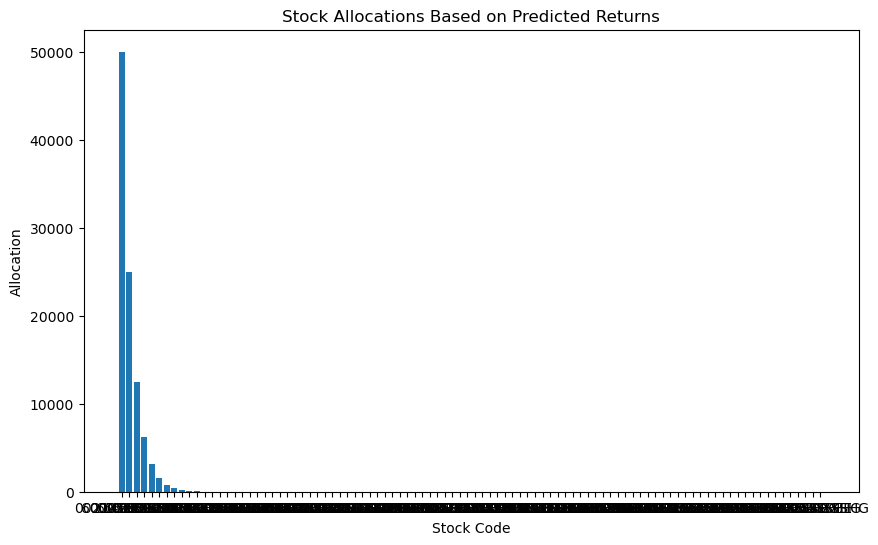

002142.XSHE: 50000.0
600019.XSHG: 25000.0
000568.XSHE: 12500.0
600031.XSHG: 6250.0
601988.XSHG: 3125.0
601155.XSHG: 1562.5
601601.XSHG: 781.25
601288.XSHG: 390.625
603185.XSHG: 195.3125
002756.XSHE: 97.65625
600884.XSHG: 48.828125
600362.XSHG: 24.4140625
601398.XSHG: 12.20703125
601138.XSHG: 6.103515625
601799.XSHG: 3.0517578125
000786.XSHE: 1.52587890625
300595.XSHE: 0.762939453125
002466.XSHE: 0.3814697265625
601816.XSHG: 0.19073486328125
600900.XSHG: 0.095367431640625
601698.XSHG: 0.0476837158203125
601688.XSHG: 0.02384185791015625
600585.XSHG: 0.011920928955078125
000301.XSHE: 0.0059604644775390625
600426.XSHG: 0.0029802322387695312
600809.XSHG: 0.0014901161193847656
300759.XSHE: 0.0007450580596923828
000651.XSHE: 0.0003725290298461914
601628.XSHG: 0.0001862645149230957
000002.XSHE: 9.313225746154785e-05
000596.XSHE: 4.6566128730773926e-05
002415.XSHE: 2.3283064365386963e-05
000800.XSHE: 1.1641532182693481e-05
601318.XSHG: 5.820766091346741e-06
000661.XSHE: 2.9103830456733704e-06
0

In [5]:

# Calculate the predicted returns for all stocks in the backtest data for the target date
returns_backtest=[]
returns = []
for code in selected_codes:
  X = X_input_original('backtest_data.csv（副本）', '2021-11-01', code)
  predicted_return = model.predict(X)[0]
  returns.append((code, predicted_return))
  returns_backtest.append(predicted_return)


# Sort the returns in descending order
sorted_returns = sorted(returns, key=lambda x: x[1], reverse=True)

# Get the history closeprice for backtest
price = data[data['windCode'] == code]['close'].values[0]
ratio=[0.3,0.5]
portfolio_value_predict=[]
portfolio_value_reality=[]

for r in ratio:
    # Allocate the cash based on the predicted returns
    cash_remaining = 100000
    cash_remaining1 = 100000
    allocations = {}
    allocations1 = {}
    for i, (code, predicted_return) in enumerate(sorted_returns):
      if predicted_return >= buy_threshold:
        # Buy the stock
        allocation = cash_remaining * r#Iterate stock trading scenarios using different allocation ratios
        cash_remaining -= allocation#Ideal remaining cash equal to primary cash minus the allocation for buying stock
        allocations[code] = allocation#Allocate specific allocation to the corresponding stocks, storing them by code in allocations[]

        shares1 = allocation // price#According to real price,calculate the real shares number of stock buying
        #allocations1[code] = shares1
        cash_remaining1 -= shares1 * price#Update cash remaining after buying at real price


      elif predicted_return <= sell_threshold:
        # Sell the stock
        allocation = -allocations.get(code, 0)#Returns the current allocation for the given stock code or 0 if the code is not found in the dictionary
        cash_remaining += allocation#Ideal remaining cash equal to primary cash plus the allocation for buying stock
        allocations[code] = 0#Set the allocation of sold stock to zero
        
        cash_remaining1 += allocation * data[data['windCode'] == code]['close'].values[0]#Update cash remaining after selling at real price

    portfolio_value_reality.append(cash_remaining1)#Store the cash remaining in list to caculate
print(portfolio_value_reality)
    
# Plot the allocations
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(allocations.keys(), allocations.values())
ax.set_xlabel('Stock Code')
ax.set_ylabel('Allocation')
ax.set_title('Stock Allocations Based on Predicted Returns')
plt.show()

for code, allocation in sorted(allocations.items(), key=lambda x: x[1], reverse=True):
    print(f"{code}: {allocation}")
    


We can utilize the trained lgbm model to forecast the next day's return value. As a result, in this trading technique, we initially chose a trading date of 2011.11.01 at random and screened out stocks with an increase rate on this date based on backtest data. Then we set a buy threshold of 0.3, a sell threshold of -0.1, and let's pretend we now have $100,000 cash. We then use a for loop to compute the anticipated returns for all the selected stocks in the backtest data for the target date and append the returns to a list. The output is the expected return on these stocks in 2021.11.02. Next,  we allocates the cash based on the predicted returns using another for loop. If the predicted return is greater than or  equal to the buy threshold,  it buys the stock by allocating 50% of the cash to these stock on a step-by-step basis.If the predicted return is less than or equal  to the sell threshold, it sells the stock by freeing up the allocation to that stock. Finally,  we plot the stock allocations using a bar plot with the stock codes on the x-axis and the allocations on the y-axis. The  plot is titled "Stock Allocations Based on Predicted Returns". and we print out the stocks we decided to buy in proportion  to their allotments

#对每只股票进行不同持仓参数分配allocation，计算回测

    
 Sell stocks
for code in sell_stocks:
    shares1 = int(allocations1.get(code, 0))
    cash_remaining1 += shares1 * data[data['windCode'] == code]['close'].values[0]
    allocations1[code] = 0
    
 Buy stocks
for code in buy_stocks:
    price = data[data['windCode'] == code]['close'].values[0]
    allocation1 = int(cash_remaining1 / len(buy_stocks))
    
    shares1 = allocation1 // price
    allocations1[code] = shares1
    cash_remaining1 -= shares1 * price

In [6]:
# Calculate the final portfolio value in different ratio and compare
for i, value in enumerate(portfolio_value_reality):
    for code, shares in allocations.items():
        #Multiplying the number of shares by the current market price, and adds it to the current total value of the portfolio
        value += shares * data[data['windCode'] == code]['close'].values[0]# Calculate portfolio_value_reality
    print(f"buy_threshold,sell_threshold: {buy_threshold,sell_threshold},Ratio: {ratio[i]}, Final portfolio real value: {value}")

buy_threshold,sell_threshold: (0.3, -0.1),Ratio: 0.3, Final portfolio real value: 5342458.07461428
buy_threshold,sell_threshold: (0.3, -0.1),Ratio: 0.5, Final portfolio real value: 5342181.32461428


 Calculate the final portfolio value
portfolio_value1 = cash_remaining1
for code, shares1 in allocations1.items():
    portfolio_value1 += shares1 * data[data['windCode'] == code]['close'].values[0]
print(f"Final portfolio value1: {portfolio_value1}")

#简单方法计算总收益，但allocation不准确
cash=0
Loop through the selected codes
for code in allocations.keys():
    # Get the closing price for the stock
    close_price = data[data['windCode'] == code]['close'].values[0]
    
    # Calculate the return for the stock
    allocation = allocations[code]
    shares = allocation / close_price
    current_value = shares * close_price
    total_return = (current_value - allocation) / allocation
    
    # Update the cash balance
    cash += current_value
    
Calculate the final portfolio value
portfolio_value = cash
    
print(portfolio_value)

    # Determine which stocks to buy or sell
    buy_stocks = []
    sell_stocks = []
    for code in data[data['tradingDate'] == date]['windCode']:
        if code in allocations:
            current_return = backtest_data[(backtest_data['tradingDate'] == date) & (backtest_data['windCode'] == code)]['return'].values[0]
            if current_return <= sell_threshold:
                sell_stocks.append(code)
        else:
            predicted_return = model.predict(X_input_original('backtest_data.csv（副本）', date, code))[0]
            if predicted_return >= buy_threshold:
                buy_stocks.append(code)
    
    # Sell stocks
    for code in sell_stocks:
        shares = allocations.pop(code)
        cash += shares * backtest_data[(backtest_data['tradingDate'] == date) & (backtest_data['windCode'] == code)]['close'].values[0]
    
    # Buy stocks
    for code in buy_stocks:
        price = backtest_data[(backtest_data['tradingDate'] == date) & (backtest_data['windCode'] == code)]['close'].values[0]
        allocation = cash / len(buy_stocks)
        shares = allocation // price
        holdings[code] = shares
        cash -= shares * price

In [12]:
# Calculate the standard deviation of predicted returns
std_dev = np.std(returns_backtest)

# Calculate the Sharpe ratio
sharpe_ratio = np.mean(returns_backtest) / std_dev

# Print the results
print(f'Standard deviation: {std_dev:.4f}')
print(f'Sharpe ratio: {sharpe_ratio:.4f}')

Standard deviation: 0.2163
Sharpe ratio: 0.3425


In [10]:
# Calculate the maximum drawdown
cum_return = np.cumprod(1 + returns_backtest) - 1
max_drawdown = np.max(np.maximum.accumulate(cum_return) - cum_return)

# Print the results
print(f'Standard deviation: {std_dev:.4f}')
print(f'Sharpe ratio: {sharpe_ratio:.4f}')
print(f'Maximum drawdown: {max_drawdown:.4f}')

TypeError: unsupported operand type(s) for +: 'int' and 'list'